In [40]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [41]:
agg_comments_df = pd.read_csv('aggression_annotated_comments.tsv', sep='\t')
agg_comments_df.head()

,rev_id,comment,year,logged_in,ns,sample,split
0,37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,True,article,random,train
1,44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,True,article,random,train
2,49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,True,article,random,train
3,89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
4,93890,This page will need disambiguation.,2002,True,article,random,train


In [42]:
agg_annot_df = pd.read_csv('aggression_annotations.tsv', sep='\t')
agg_annot_df.head()

,rev_id,worker_id,aggression,aggression_score
0,37675,1362,1.0,-1.0
1,37675,2408,0.0,1.0
2,37675,1493,0.0,0.0
3,37675,1439,0.0,0.0
4,37675,170,0.0,0.0


In [43]:
agg_annot_df.isnull().sum()

rev_id              0
worker_id           0
aggression          0
aggression_score    0
dtype: int64

In [44]:
# create a new dataframe to calculate the mean of the 'aggression' for each comment
agg_1_df = agg_annot_df.groupby(['rev_id']).mean()
agg_1_df.head()

,worker_id,aggression,aggression_score
rev_id,,,
37675,972.100000,0.100000,0.000000
44816,2248.222222,0.000000,0.111111
49851,2647.400000,0.000000,0.100000
89320,2970.888889,0.444444,-0.444444
93890,890.000000,0.000000,0.333333


In [45]:
# identify as aggressive if at least five reviewers reported the comment to be aggressive
agg_1_df['label'] = agg_1_df['aggression'].map(lambda x: 1 if x>= 0.5 else 0)

In [46]:
agg_1_df['label'].value_counts(normalize=True)

0    0.853121
1    0.146879
Name: label, dtype: float64

In [47]:
# create a new dataframe to calculate the total score of the 'aggression score' for each comment
agg_2_df = agg_annot_df.groupby(['rev_id']).sum()
agg_2_df.head()

,worker_id,aggression,aggression_score
rev_id,,,
37675,9721,1.0,0.0
44816,20234,0.0,1.0
49851,26474,0.0,1.0
89320,26738,4.0,-4.0
93890,8010,0.0,3.0


In [48]:
# identify as aggressive if the total score is -5 or less for 'aggressive score'
agg_2_df['label'] = agg_2_df['aggression_score'].map(lambda x: 1 if x<= -5 else 0)


In [49]:
agg_2_df['label'].value_counts(normalize=True)

0    0.791048
1    0.208952
Name: label, dtype: float64

We will identify "aggression" if at least half of the reviewers reported the comment to be aggressive. This is based on the 'aggression' column which is a binary categorical variable that is 1 if any aggression was detected by the reviewer and 0 if the comment was perceived as neutral or positive by the reviewer. The label previously created based on the 'aggression score' may include opportunities for some reviewers to inflate the results, therefore aggression may be better identified when at least half of the viewers perceived the comment to be aggressive.

In [50]:
aggression_df = agg_comments_df.merge(agg_1_df, how='left', on='rev_id')
aggression_df.head()

,rev_id,comment,year,logged_in,ns,sample,split,worker_id,aggression,aggression_score,label
0,37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,True,article,random,train,972.100000,0.100000,0.000000,0
1,44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,True,article,random,train,2248.222222,0.000000,0.111111,0
2,49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,True,article,random,train,2647.400000,0.000000,0.100000,0
3,89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev,2970.888889,0.444444,-0.444444,0
4,93890,This page will need disambiguation.,2002,True,article,random,train,890.000000,0.000000,0.333333,0


In [51]:
aggression_df['label'].value_counts(normalize=True)

0    0.853121
1    0.146879
Name: label, dtype: float64

In [52]:
# remove the 'NEWLINE_TOKEN' text found at the beginning and ending of the comment text
for i in range(len(aggression_df['comment'])):
        x = aggression_df['comment'][i].replace('NEWLINE_TOKEN','')
        aggression_df['comment'][i] = x
aggression_df.head()

<ipython-input-52-5bc6df47d034>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aggression_df['comment'][i] = x


,rev_id,comment,year,logged_in,ns,sample,split,worker_id,aggression,aggression_score,label
0,37675,`-This is not ``creative``. Those are the dic...,2002,True,article,random,train,972.100000,0.100000,0.000000,0
1,44816,`:: the term ``standard model`` is itself less...,2002,True,article,random,train,2248.222222,0.000000,0.111111,0
2,49851,"True or false, the situation as of March 2002 ...",2002,True,article,random,train,2647.400000,0.000000,0.100000,0
3,89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev,2970.888889,0.444444,-0.444444,0
4,93890,This page will need disambiguation.,2002,True,article,random,train,890.000000,0.000000,0.333333,0


In [53]:
comments_aggressive = aggression_df[aggression_df['label']==1]['comment']
comments_nonaggressive = aggression_df[aggression_df['label']==0]['comment']

In [54]:
# Instantiate CountVectorizer with default hyperparameters and stopwords
cvec = CountVectorizer(stop_words = 'english')

In [55]:
# Fit and transform the non-aggressive text
comments_aggressive = cvec.fit_transform(comments_aggressive)

In [56]:
# convert aggressive Count-Vectorized text to dataframe
comments_aggressive_df = pd.DataFrame(comments_aggressive.todense(),
                         columns=cvec.get_feature_names())

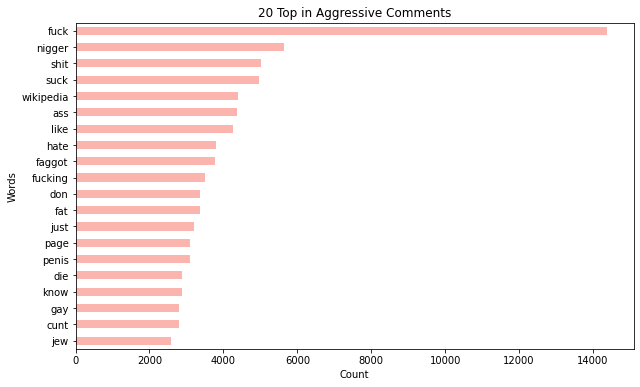

In [57]:
# Plot 20 top words in aggressive comments
plt.figure(figsize=(10,6))
comments_aggressive_df.sum().sort_values(ascending=True).tail(20).plot(kind='barh', cmap='Pastel1')
plt.xlabel('Count')
plt.ylabel('Words')
plt.title('20 Top in Aggressive Comments');